# Lien entre endettement et croissance

## I - Initialisation et récupération des données

On télécharge les modules et fonctions nécessaires :

In [48]:
!pip install -r requirements.txt

# Modules :
import os
import s3fs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from IPython.display import display
import importlib
import openpyxl as xlrd

# Fonctions :
from scripts import get_data
from scripts import data_vis
from scripts import data_clean

# Reload automatique pour travailler en continu :
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Récupération des données :

In [12]:
df = get_data.get_cloud_csv("donnees")

Aperçu :

In [13]:
df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Zone de référence,FREQ,Fréquence d'observation,MEASURE,Mesure,...,OBS_VALUE,Valeur d'observation,OBS_STATUS,Statut d'observation,UNIT_MULT,Multiplicateur d'unité,DECIMALS,Décimales,BASE_PER,Période de base
0,DATAFLOW,OECD.SDD.STES:DSD_KEI@DF_KEI(4.0),Indicateurs économiques clés à court-terme,I,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,...,108.838782,NaN,A,Normal value,0,Units,1,One,2015.0,NaN
1,DATAFLOW,OECD.SDD.STES:DSD_KEI@DF_KEI(4.0),Indicateurs économiques clés à court-terme,I,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,...,108.401479,NaN,A,Normal value,0,Units,1,One,2015.0,NaN
2,DATAFLOW,OECD.SDD.STES:DSD_KEI@DF_KEI(4.0),Indicateurs économiques clés à court-terme,I,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,...,105.877126,NaN,A,Normal value,0,Units,1,One,2015.0,NaN
3,DATAFLOW,OECD.SDD.STES:DSD_KEI@DF_KEI(4.0),Indicateurs économiques clés à court-terme,I,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,...,103.859348,NaN,A,Normal value,0,Units,1,One,2015.0,NaN
4,DATAFLOW,OECD.SDD.STES:DSD_KEI@DF_KEI(4.0),Indicateurs économiques clés à court-terme,I,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,...,99.915301,NaN,A,Normal value,0,Units,1,One,2015.0,NaN


## II - Nettoyage des données

Suppression de colonnes inutiles :

In [14]:
# Nous supprimons les colonnes qui ne nous serons pas utiles :
colonnes_inutiles = ["STRUCTURE", # Dataflow
                     "STRUCTURE_ID", # OOECD.SDD.STES:DSD_KEI@DF_KEI(4.0)
                     "STRUCTURE_NAME", # Indicateurs économiques clés à court-terme
                     "ACTION", # I
                     "DECIMALS", # 1
                     "Décimales" # One
                    ]
df = df.drop(columns=colonnes_inutiles, errors='ignore')

# On nettoie les données en supprimants les observations avec des valeurs manquantes :
df.dropna(subset=['TIME_PERIOD', 'OBS_VALUE'], inplace=True)

# Apperçu :
df.head()

,REF_AREA,Zone de référence,FREQ,Fréquence d'observation,MEASURE,Mesure,UNIT_MEASURE,Unité de mesure,ACTIVITY,Activité économique,...,TIME_PERIOD,Période temporelle,OBS_VALUE,Valeur d'observation,OBS_STATUS,Statut d'observation,UNIT_MULT,Multiplicateur d'unité,BASE_PER,Période de base
0,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,2007-Q4,NaN,108.838782,NaN,A,Normal value,0,Units,2015.0,NaN
1,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,2008-Q1,NaN,108.401479,NaN,A,Normal value,0,Units,2015.0,NaN
2,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,2008-Q2,NaN,105.877126,NaN,A,Normal value,0,Units,2015.0,NaN
3,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,2008-Q3,NaN,103.859348,NaN,A,Normal value,0,Units,2015.0,NaN
4,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,2008-Q4,NaN,99.915301,NaN,A,Normal value,0,Units,2015.0,NaN


Ajout d'une colonne date harmoniser au format 01/MM/AAAA :

In [19]:
# On parse une seule fois "TIME_PERIOD" pour tout le DataFrame,
# Et on ajoute une colonne "date" (format "AAAA-MM-JJ") et une colonne "year" :
df["date"] = df["TIME_PERIOD"].apply(data_clean.parse_time_period)
df["year"] = df["date"].dt.year

# Apperçu :
df.head()

,REF_AREA,Zone de référence,FREQ,Fréquence d'observation,MEASURE,Mesure,UNIT_MEASURE,Unité de mesure,ACTIVITY,Activité économique,...,OBS_VALUE,Valeur d'observation,OBS_STATUS,Statut d'observation,UNIT_MULT,Multiplicateur d'unité,BASE_PER,Période de base,date,year
0,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,108.838782,NaN,A,Normal value,0,Units,2015.0,NaN,2007-10-01,2007
1,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,108.401479,NaN,A,Normal value,0,Units,2015.0,NaN,2008-01-01,2008
2,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,105.877126,NaN,A,Normal value,0,Units,2015.0,NaN,2008-04-01,2008
3,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,103.859348,NaN,A,Normal value,0,Units,2015.0,NaN,2008-07-01,2008
4,OECD,OCDE,Q,Trimestrielle,PRVM,Production volume,IX,Indice,F,Construction,...,99.915301,NaN,A,Normal value,0,Units,2015.0,NaN,2008-10-01,2008


## III - Statistiques descriptives et visualisations


Valeurs possibles pour certaines colonnes :

In [15]:
print(df["REF_AREA"].unique())
print(df["Mesure"].unique())
print(df["Activité économique"].unique())

['OECD' 'EA19' 'BRA' 'GBR' 'USA' 'HRV' 'CAN' 'DEU' 'NZL' 'MEX' 'BEL' 'ITA'
 'AUT' 'CZE' 'DNK' 'FIN' 'SVN' 'POL' 'ISR' 'HUN' 'CRI' 'CHL' 'GRC' 'NLD'
 'ISL' 'LUX' 'ESP' 'KOR' 'AUS' 'IRL' 'SVK' 'SWE' 'TUR' 'FRA' 'JPN' 'LTU'
 'EST' 'LVA' 'PRT' 'NOR' 'RUS' 'ZAF' 'EA20' 'EU27_2020' 'OECDE' 'G7' 'CHE'
 'COL' 'IND' 'CHN' 'IDN' 'ARG' 'SAU' 'G20']
['Production volume' 'Ensemble du commerce de détail volume'
 'Prix à la production' 'Gains horaires'
 "Indicateurs de confiance de l'entreprise"
 'Immatriculation des voitures particulières' 'Prix à la consommation'
 'Cours des actions' 'Taux de change nominal' 'M3' 'M1'
 'Indicateurs de confiance des ménages' "Taux d'intérèt à long court"
 "Taux d'intérèt à long terme"
 "Taux d'intérèt immédiats, taux de l'argent, taux interbancaire"
 'Exportations de marchandises' 'Importations de marchandises' 'Emploi'
 'Taux de chômage'
 'Balance des transactions courantes en pourcentage du PIB'
 'Dépense de consommation finale des administrations publiques, volum

### PIB comme mesure de croissance

In [20]:
# Commençons par sélectionner le PIB comme première mesure de la croissance :
df_gdp = df[df["Mesure"] == "Produit intérieur brut, volume"].copy()

# Statistiques descriptives de la colonne sur les valeurs du taux de croissance du PIB (tous pays confondus) :
print(df_gdp["OBS_VALUE"].describe())
print("Unité de mesure :", df_gdp["Unité de mesure"].unique())

count    19178.000000
mean         2.056193
std          3.187316
min        -22.780573
25%          0.466395
50%          1.558061
75%          3.505001
max         28.053995
Name: OBS_VALUE, dtype: float64
Unité de mesure : ['Taux de croissance']


Par pays :

In [21]:
# Il est plus intéressant de regarder les données par pays :
df_gdp.groupby("Zone de référence")['OBS_VALUE'].describe()

,count,mean,std,min,25%,50%,75%,max
Zone de référence,,,,,,,,
Afrique du Sud,647.0,1.920860,2.719543,-16.842584,0.411022,1.413826,3.441392,19.177351
Allemagne,549.0,1.253576,2.052253,-10.681102,0.120310,1.031101,2.324773,11.615195
Australie,647.0,2.312342,2.177075,-6.751062,0.754348,2.067522,3.837774,10.290724
Autriche,369.0,1.283936,2.322484,-14.004243,0.292808,1.107945,2.514585,13.785214
Belgique,299.0,1.250340,2.112726,-12.054526,0.380132,1.070627,1.962457,14.510036
Brésil,287.0,1.599531,2.654601,-10.143278,0.327876,1.307392,3.090237,12.258169
Canada,639.0,2.102032,2.398878,-12.241524,0.660449,1.753114,3.471413,12.893280
Chili,289.0,2.454502,3.368837,-14.324513,0.696727,2.052174,4.465950,17.551873
Chine (République populaire de),256.0,7.057813,4.201029,-10.500000,3.100000,7.550000,9.925000,18.900000


In [22]:
# On lisse les données (on a plusieurs valeurs par années ; on agrège)
df_gdp_smooth = df_gdp.groupby(["REF_AREA", "year"])["OBS_VALUE"].mean().reset_index()
df_gdp_smooth["date"] = pd.to_datetime(df_gdp_smooth["year"], format="%Y")

print("Données agrégées par année :")
print(df_gdp_smooth.head())

Données agrégées par année :
  REF_AREA  year  OBS_VALUE       date
0      AUS  1960   0.922930 1960-01-01
1      AUS  1961  -0.010223 1961-01-01
2      AUS  1962   3.988019 1962-01-01
3      AUS  1963   4.460715 1963-01-01
4      AUS  1964   4.268924 1964-01-01


On s'intéresse à la période 2000 - 2025 incluant les deux crises majeures repérées :
- Crise économique de 2008
- Crise sanitaire du COVID de 2019

In [24]:
# On filtre les données lissées à partir de 2000 :
df_gdp_smooth_2000 = df_gdp_smooth[df_gdp_smooth["year"] >= 2000]

# Liste des pays à comparer :
pays = ["USA", "CHN", "IND", "RUS", "FRA"]

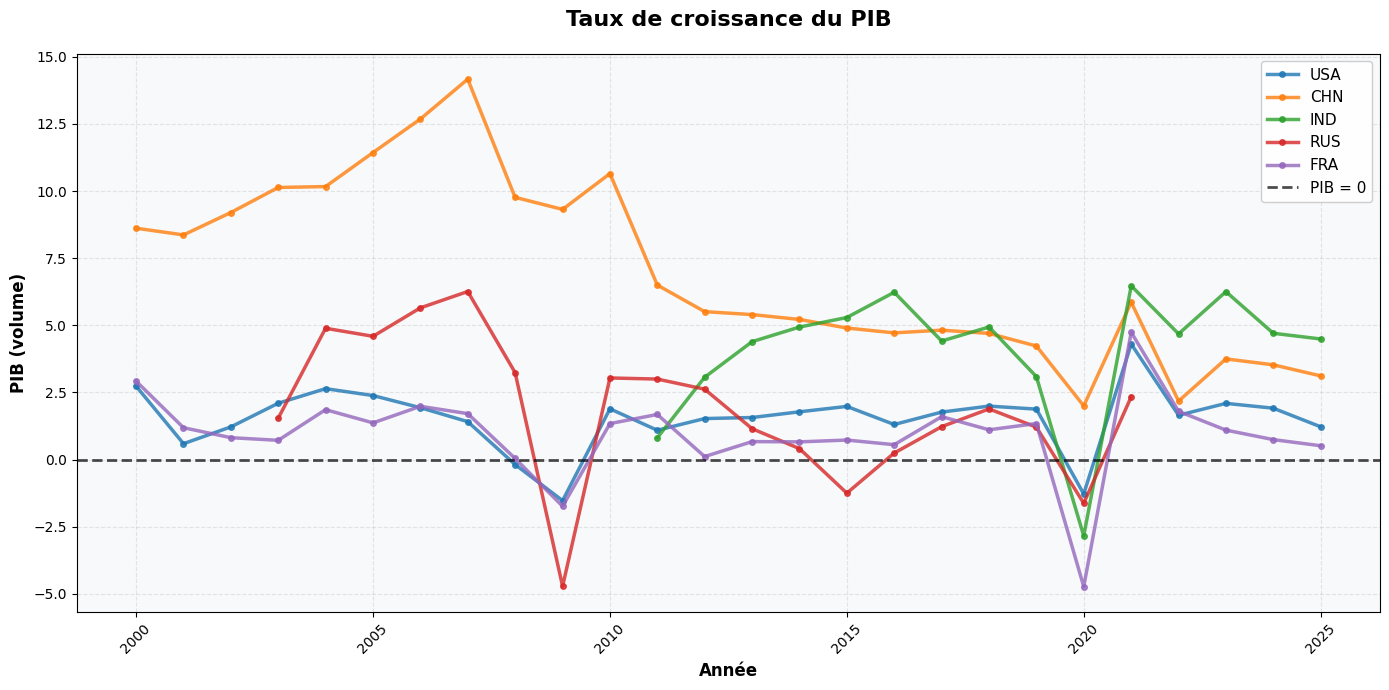

In [26]:
data_vis.croissance_pib(pays, df_gdp_smooth_2000)

### Régression M1, M3 et salaires horaires sur la production

Nous choisissons maintenant M1 et M3 comme indicateur de dette (masses monétaires) car une augmentation de M1 ou M3 signifie probablement une injection d'argent par l'État dans l'économie (= financement public).
Aussi, des salaires horaires plus forts favorisent en théorie la production.

(Valide ? ... Pas trop)

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


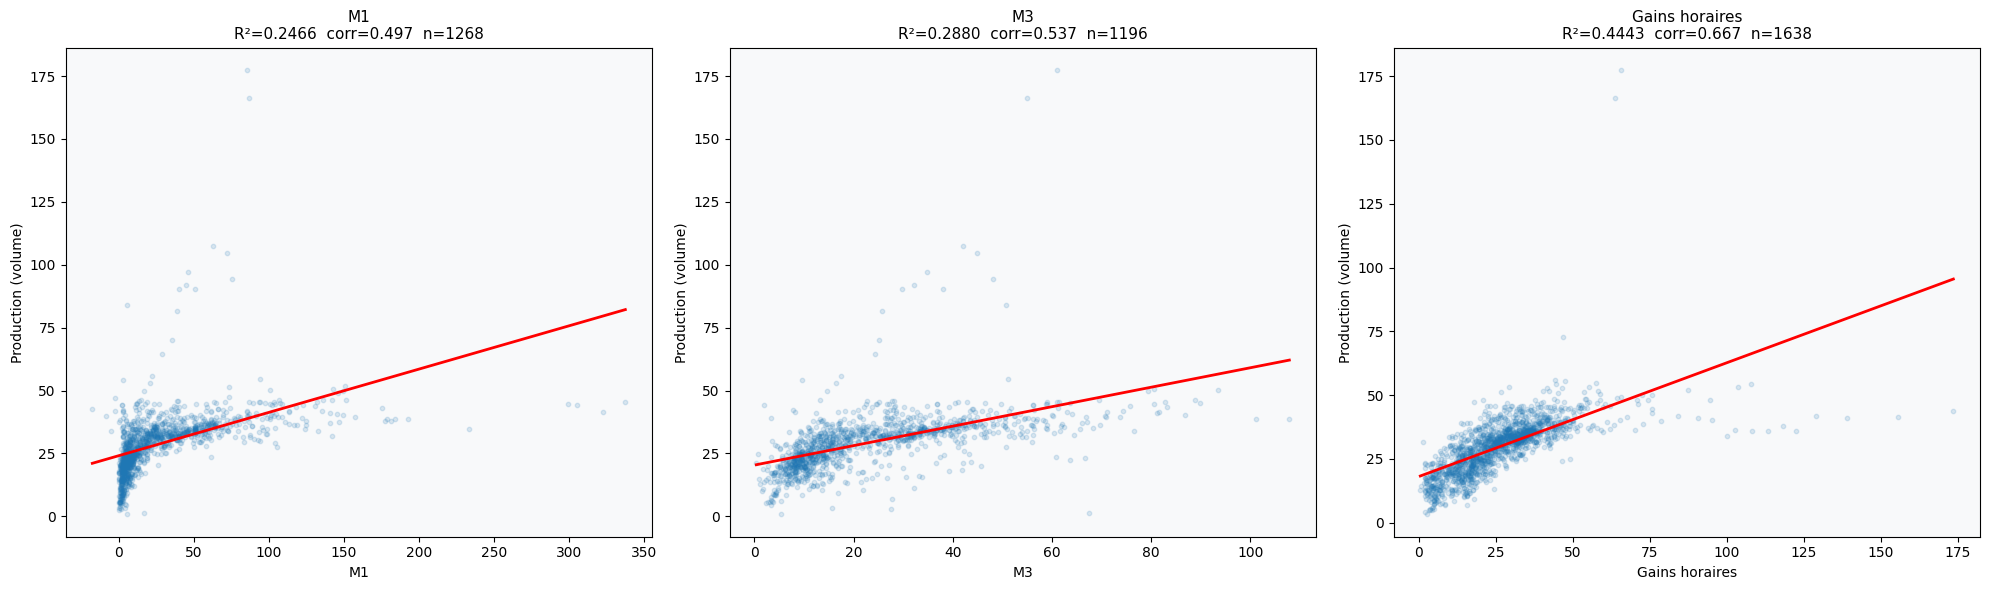


RÉCAPITULATIF DES RÉGRESSIONS :


,variable,r2,coef,intercept,corr,n
2,Gains horaires,0.444276,0.446408,18.020419,0.666540,1638
1,M3,0.287965,0.386800,20.373269,0.536624,1196
0,M1,0.246578,0.172156,24.080856,0.496566,1268


In [ ]:
importlib.reload(data_vis)  # <- recharge le module...
data_vis.reg_m1_m3_salaire(df)

C'est cohérent. A court terme, une augmentation de M1 ou M3 augment la production. Le salaire horaire favorise aussi la production.

### Dette gouvernementale et des ménages

In [53]:
%pip install openpyxl xlrd -q

# Lecture et exploration des fichiers de dette (format .xls ancien)
# Utiliser xlrd avec ignore_workbook_corruption
import xlrd

# Chemins vers les fichiers
fichier_gouv = "données/debt_gouv.xls"
fichier_household = "données/debt_household.xls"

# Ouvrir les fichiers .xls
wb_gouv = xlrd.open_workbook(fichier_gouv, on_demand=True, ignore_workbook_corruption=True)
wb_household = xlrd.open_workbook(fichier_household, on_demand=True, ignore_workbook_corruption=True)

# Récupérer la première feuille
ws_gouv = wb_gouv.sheet_by_index(0)
ws_household = wb_household.sheet_by_index(0)

# Convertir en DataFrame
data_gouv = []
for row_idx in range(ws_gouv.nrows):
    row = []
    for col_idx in range(ws_gouv.ncols):
        row.append(ws_gouv.cell_value(row_idx, col_idx))
    data_gouv.append(row)

data_household = []
for row_idx in range(ws_household.nrows):
    row = []
    for col_idx in range(ws_household.ncols):
        row.append(ws_household.cell_value(row_idx, col_idx))
    data_household.append(row)

# Créer les DataFrames (première ligne = headers)
df_debt_gouv = pd.DataFrame(data_gouv[1:], columns=data_gouv[0])
df_debt_household = pd.DataFrame(data_household[1:], columns=data_household[0])

print("Structure debt_gouv:")
print(df_debt_gouv.head())
print("\nColonnes debt_gouv:")
print(df_debt_gouv.columns.tolist())
print("\nStructure debt_household:")
print(df_debt_household.head())
print("\nColonnes debt_household:")
print(df_debt_household.columns.tolist())



Note: you may need to restart the kernel to use updated packages.
Structure debt_gouv:
  General Government Debt (Percent of GDP)     1950.0     1951.0     1952.0  \
0                                                                             
1                                   Canada  87.749903  76.520917  70.054312   
2                                   France    no data    no data    no data   
3                                  Germany  18.811777  16.686637  15.705143   
4                                    Italy  30.985153  31.419462  33.488384   

      1953.0     1954.0     1955.0     1956.0     1957.0     1958.0  ...  \
0                                                                    ...   
1  67.192534  68.277314  66.456116  58.404764  57.632371  63.096356  ...   
2    no data    no data    no data    no data    no data    no data  ...   
3  20.561889  21.810273  20.210323  18.810424  18.077472  17.935647  ...   
4  34.436082  36.245068    36.2088  35.250606  34.633152  

In [54]:
# Nettoyage et préparation des données de dette
# Identifier les colonnes d'années (numériques)
cols_gouv = df_debt_gouv.columns.tolist()
cols_household = df_debt_household.columns.tolist()

print("Colonnes debt_gouv:", cols_gouv)
print("Colonnes debt_household:", cols_household)
print("\nPremières lignes debt_gouv:")
print(df_debt_gouv.head())

Colonnes debt_gouv: ['General Government Debt (Percent of GDP)', 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0, 2024.0]
Colonnes debt_household: ['Household debt, loans and debt securities (Percent of GDP)', 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0,

Évolution de la dette gouvernementale :

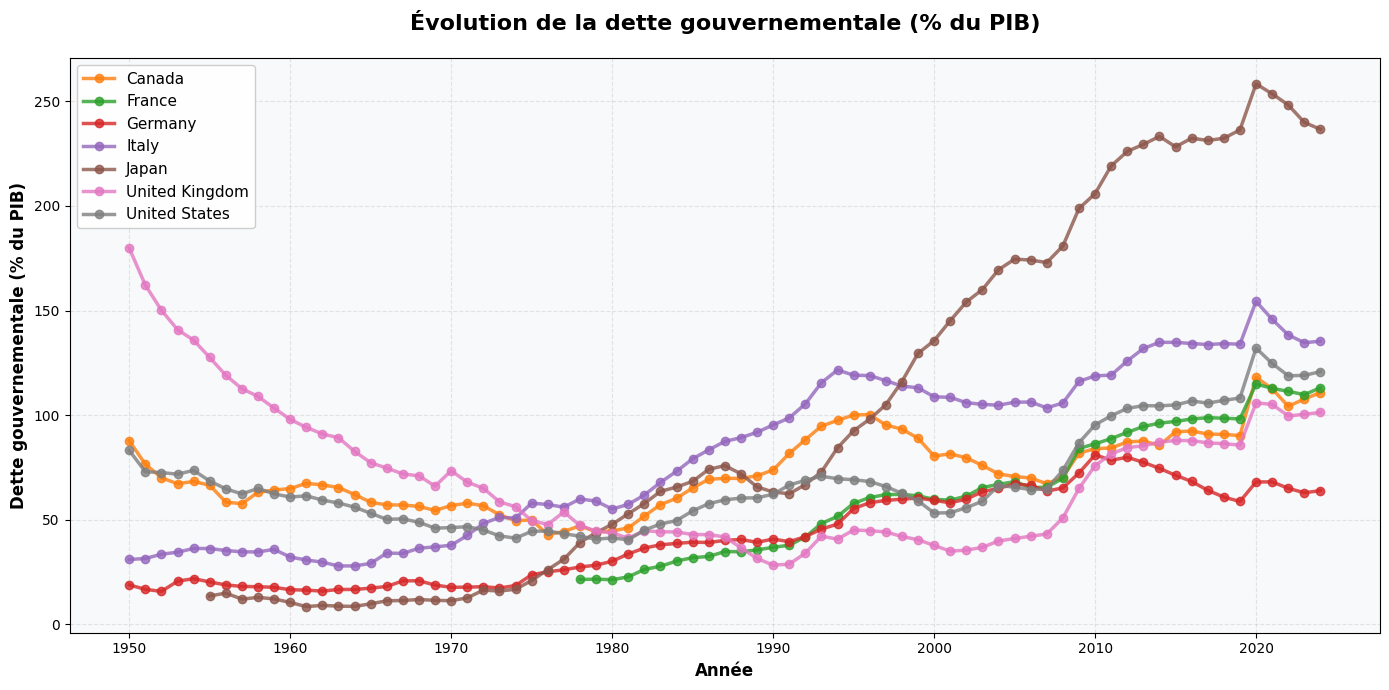

In [56]:
data_vis.dette_gouv(df_debt_gouv)

Évolution de la dette des ménages :

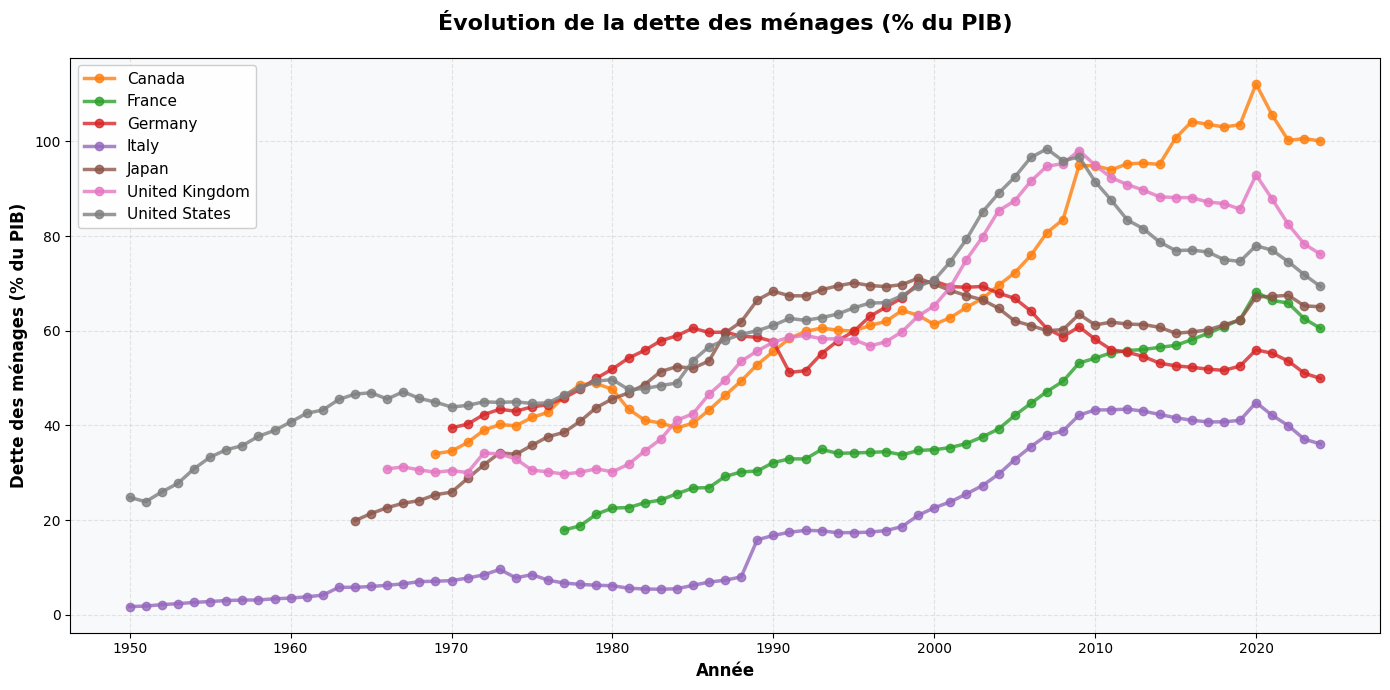

In [57]:
data_vis.dette_menages(df_debt_household)

Revenons au taux de croissance du PIB pour les pays avec données de dette :

In [58]:
# Les pays disponibles dans les données de dette sont : Canada, France, Allemagne, Italie, Japon, Royaume-Uni, États-Unis

# Codes pays correspondant aux données de dette
pays_dette = {
    'Canada': 'CAN',
    'France': 'FRA',
    'Allemagne': 'DEU',
    'Italie': 'ITA',
    'Japon': 'JPN',
    'Royaume-Uni': 'GBR',
    'États-Unis': 'USA'
}

# Récupérer les données de PIB volume
df_pib = df[df['Mesure'] == 'Produit intérieur brut, volume'].copy()

# Agréger par pays et année
df_pib_agg = df_pib.groupby(['REF_AREA', 'year'])['OBS_VALUE'].mean().reset_index()
df_pib_agg['date'] = pd.to_datetime(df_pib_agg['year'], format='%Y')

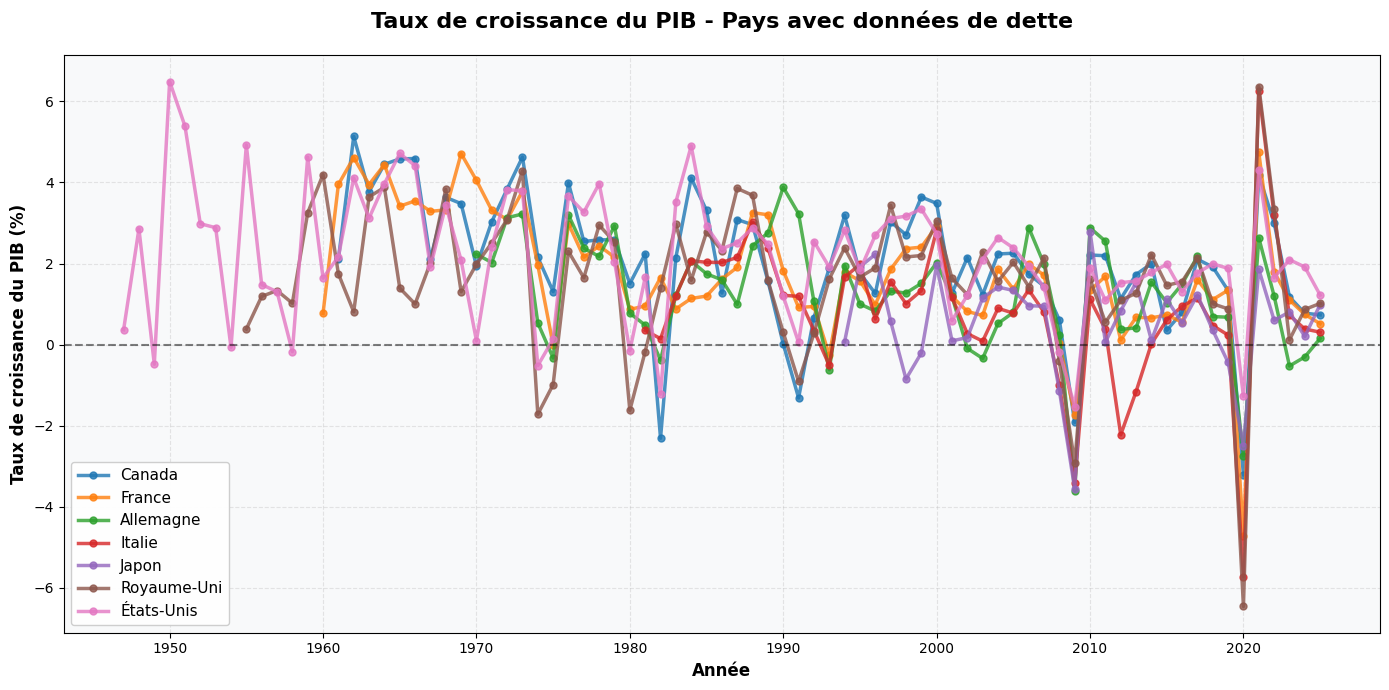

In [59]:
data_vis.taux_croissance_pib_pay_avec_dette(df_pib_agg, pays_dette)

Comparaison dette-PIB pour certains pays :

In [60]:
# Mapping des noms de pays
country_names = {
    'France': 'France',
    'United States': 'United States',
    'Canada': 'Canada',
    'United Kingdom': 'United Kingdom'
}

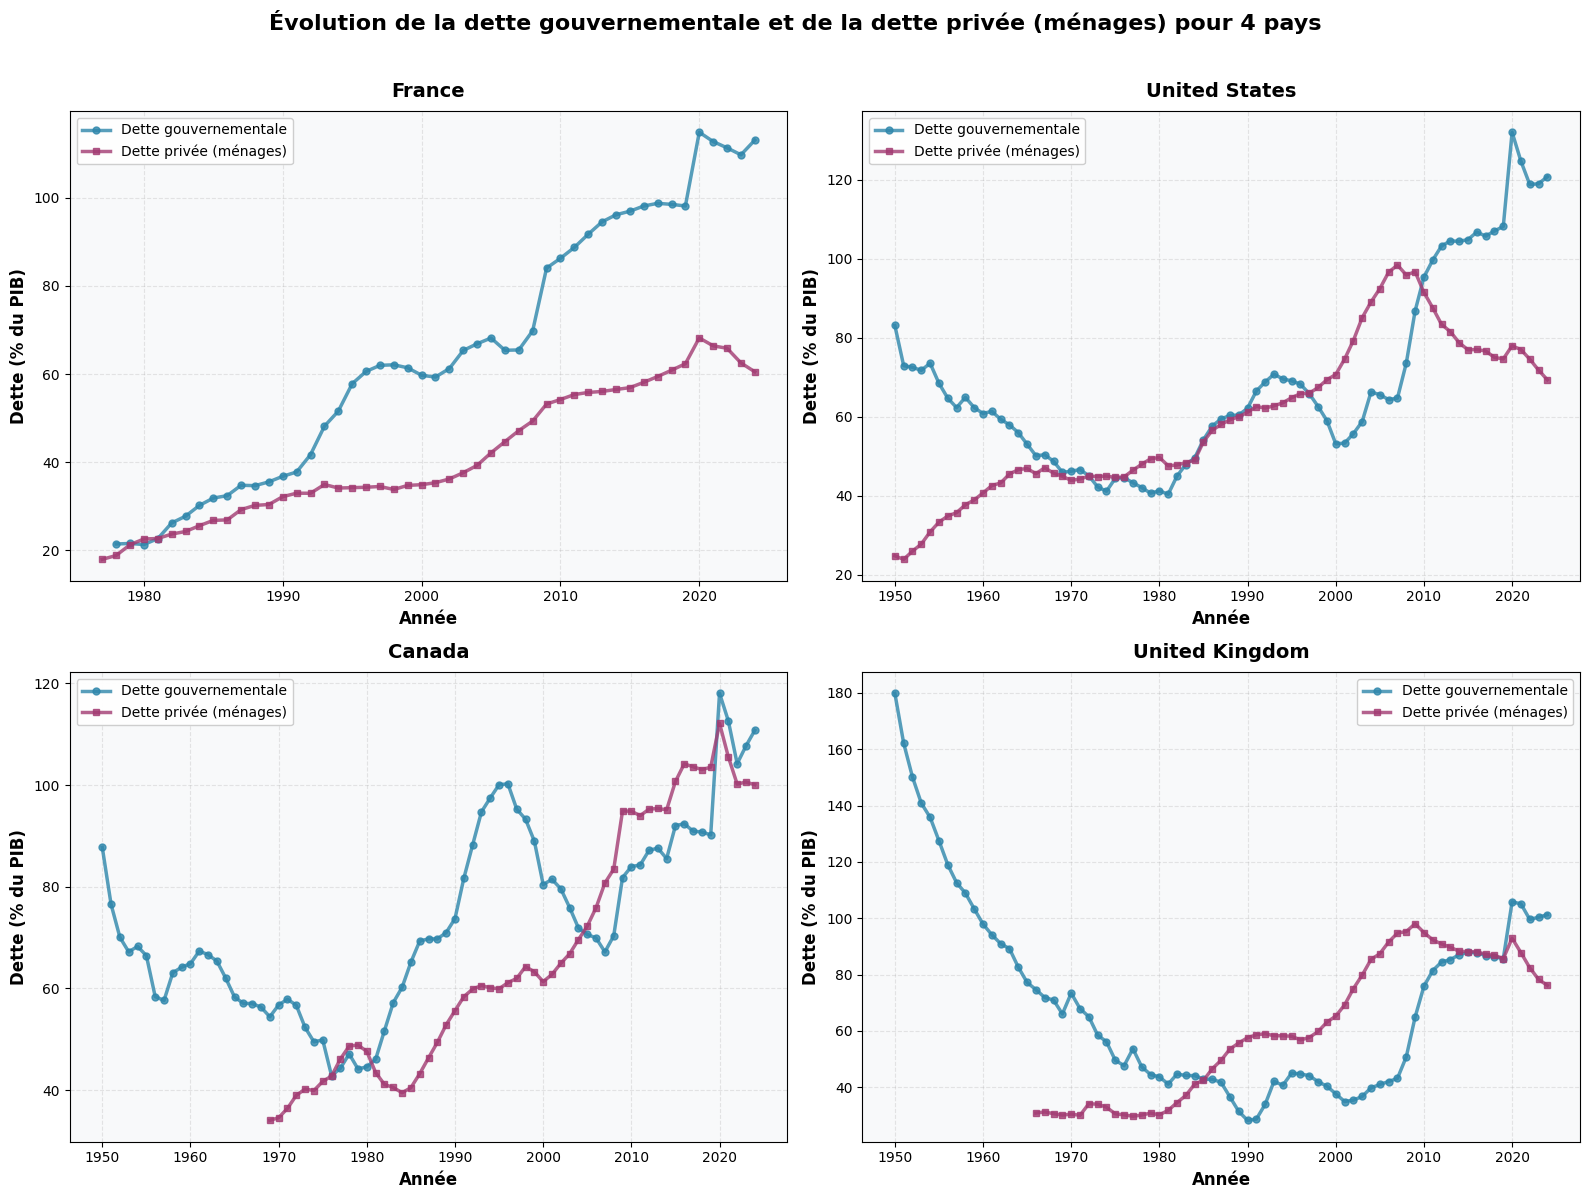

In [61]:
data_vis.comparaison_pays_dette_pib(country_names, df_debt_gouv, df_debt_household)

Exemple : France

In [62]:
# Préparer les données pour la France
# 1. Extraire les données de dette gouvernementale pour la France
france_gouv_row = df_debt_gouv[df_debt_gouv.iloc[:, 0].str.contains('France', case=False, na=False)]
france_household_row = df_debt_household[df_debt_household.iloc[:, 0].str.contains('France', case=False, na=False)]

# 2. Extraire le taux de croissance du PIB pour la France
df_pib_france = df[df['Mesure'] == 'Produit intérieur brut, volume'].copy()
df_pib_france = df_pib_france[df_pib_france['REF_AREA'] == 'FRA']
df_pib_france_agg = df_pib_france.groupby('year')['OBS_VALUE'].mean().reset_index()
df_pib_france_agg.columns = ['year', 'Taux_Croissance_PIB']

# Extraire les données de dette gouvernementale
years_gouv = []
dette_gouv = []
if len(france_gouv_row) > 0:
    row = france_gouv_row.iloc[0]
    for col in df_debt_gouv.columns[1:]:
        try:
            year = float(col) if str(col).replace('.', '').isdigit() else None
            if year and pd.notna(row[col]) and row[col] != 'no data' and row[col] != '':
                years_gouv.append(int(year))
                dette_gouv.append(float(row[col]))
        except (ValueError, TypeError):
            pass

df_dette_gouv_france = pd.DataFrame({'year': years_gouv, 'Dette_Gouv_PIB': dette_gouv})

# Extraire les données de dette des ménages
years_household = []
dette_household = []
if len(france_household_row) > 0:
    row = france_household_row.iloc[0]
    for col in df_debt_household.columns[1:]:
        try:
            year = float(col) if str(col).replace('.', '').isdigit() else None
            if year and pd.notna(row[col]) and row[col] != 'no data' and row[col] != '':
                years_household.append(int(year))
                dette_household.append(float(row[col]))
        except (ValueError, TypeError):
            pass

df_dette_household_france = pd.DataFrame({'year': years_household, 'Dette_Menages_PIB': dette_household})

# Fusionner toutes les données
df_france_analyse = df_pib_france_agg.merge(df_dette_gouv_france, on='year', how='inner')
df_france_analyse = df_france_analyse.merge(df_dette_household_france, on='year', how='inner')

print("Données combinées pour la France :")
print(df_france_analyse.head(10))
print(f"\nNombre d'années disponibles : {len(df_france_analyse)}")
print(f"Période couverte : {df_france_analyse['year'].min():.0f} - {df_france_analyse['year'].max():.0f}")

Données combinées pour la France :
   year  Taux_Croissance_PIB  Dette_Gouv_PIB  Dette_Menages_PIB
0  1978             2.436924       21.425996          18.816633
1  1979             2.155816       21.538828          21.263104
2  1980             0.868305       21.298485          22.562894
3  1981             0.953697       22.639930          22.666085
4  1982             1.651585       26.201027          23.675229
5  1983             0.879943       27.733164          24.262884
6  1984             1.138713       30.190666          25.581914
7  1985             1.197318       31.851217          26.788228
8  1986             1.615550       32.395672          26.887720
9  1987             1.907847       34.755291          29.230621

Nombre d'années disponibles : 47
Période couverte : 1978 - 2024


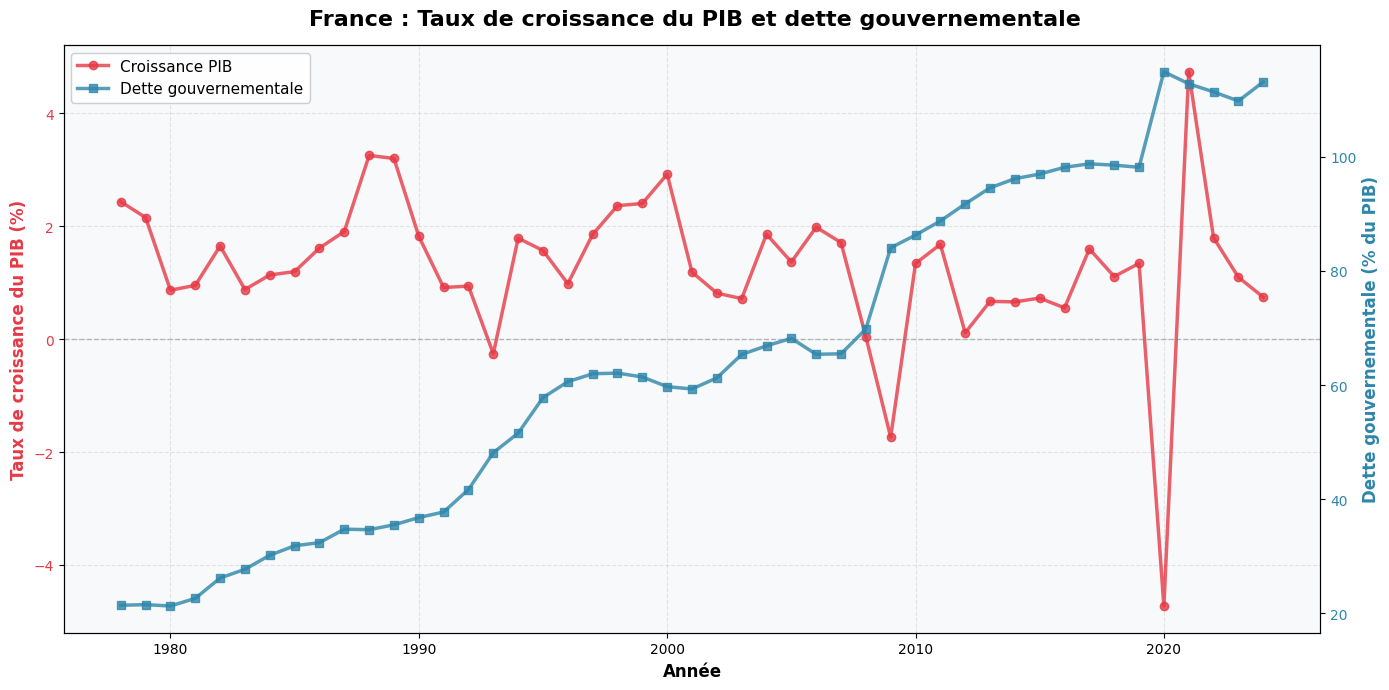

In [64]:
data_vis.pib_dette_gouv_france(df_france_analyse)

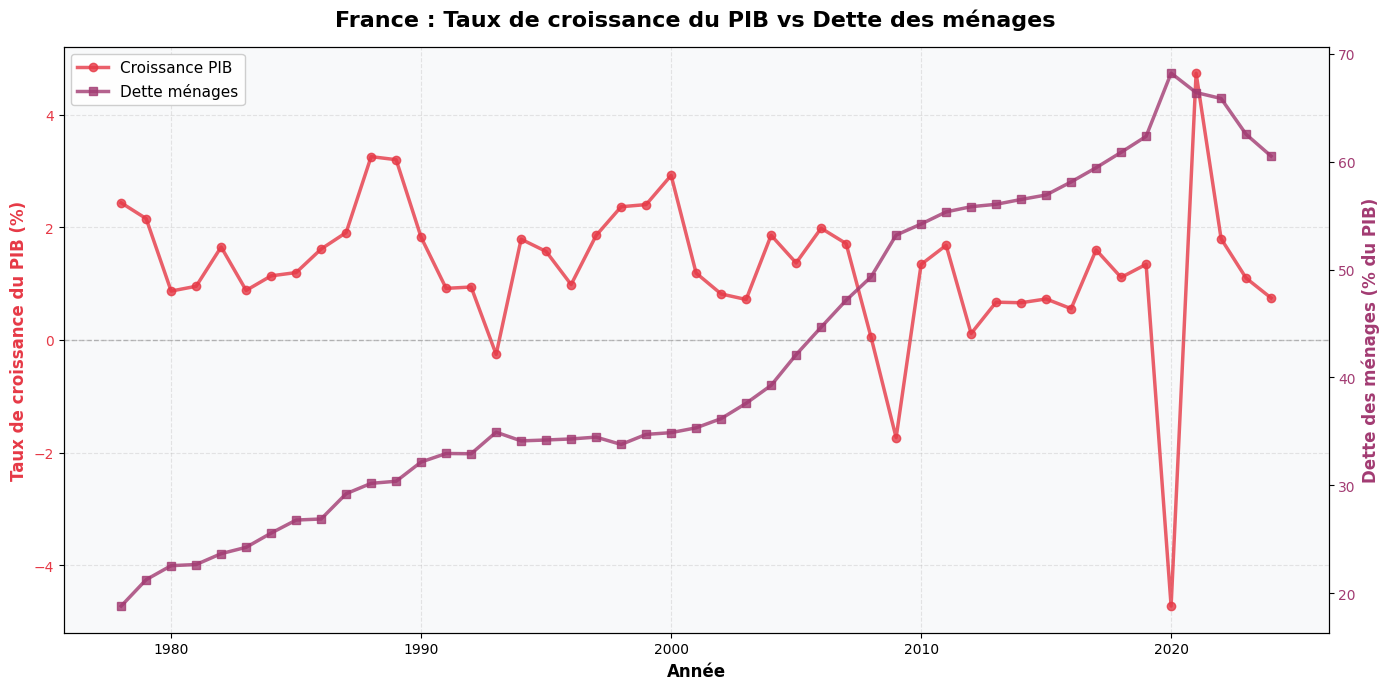

In [65]:
data_vis.pib_dette_menages_france(df_france_analyse)

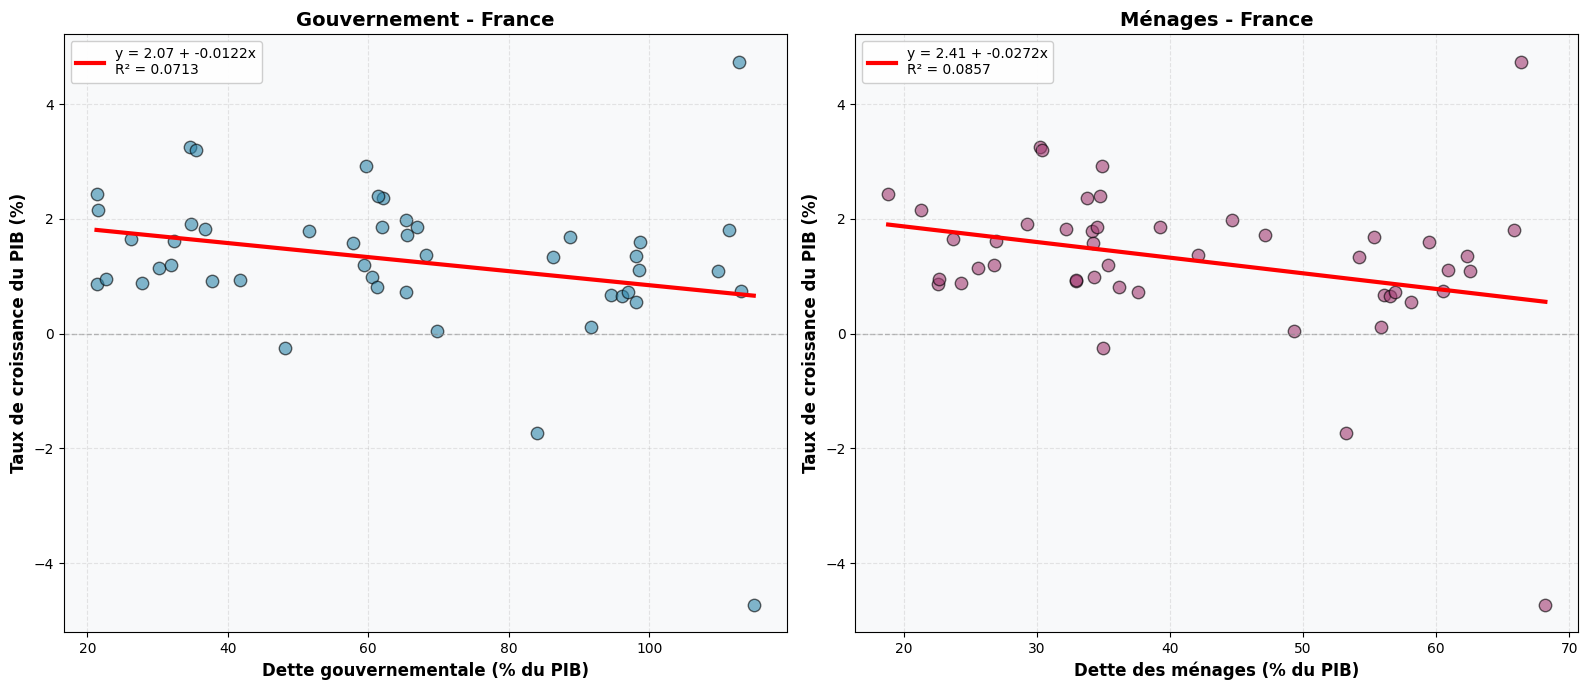


RÉSULTATS DES RÉGRESSIONS LINÉAIRES - FRANCE

1. DETTE GOUVERNEMENTALE vs CROISSANCE DU PIB :
   Équation : Croissance PIB = 2.07 + -0.0122 × Dette_Gouv
   Coefficient de corrélation (R²) : 0.0713
   Interprétation : Chaque augmentation de 1% de la dette gouvernementale (% PIB)
                    est associée à une variation de -0.0122% de la croissance du PIB

2. DETTE DES MÉNAGES vs CROISSANCE DU PIB :
   Équation : Croissance PIB = 2.41 + -0.0272 × Dette_Ménages
   Coefficient de corrélation (R²) : 0.0857
   Interprétation : Chaque augmentation de 1% de la dette des ménages (% PIB)
                    est associée à une variation de -0.0272% de la croissance du PIB



In [66]:
data_vis.reg_dette_pib_france(df_france_analyse)

### Régressions multi-pays (1991-2012) : Chaque point = Pays + Année


RÉGRESSIONS ZONE EURO ÉTENDUE (1991-2012)

Pays dans le dataset : 11
  Allemagne, Autriche, Belgique, Espagne, Finlande, France, Grèce, Irlande, Italie, Pays-Bas, Portugal

Régression - Dette gouvernementale vs Croissance PIB
  Nombre d'observations : 224
  Nombre de pays : 11
  Équation : Croissance = 2.3059 + -0.0139 × Dette_Gouv
  R² : 0.0337
  Pente (coefficient) : -0.0139


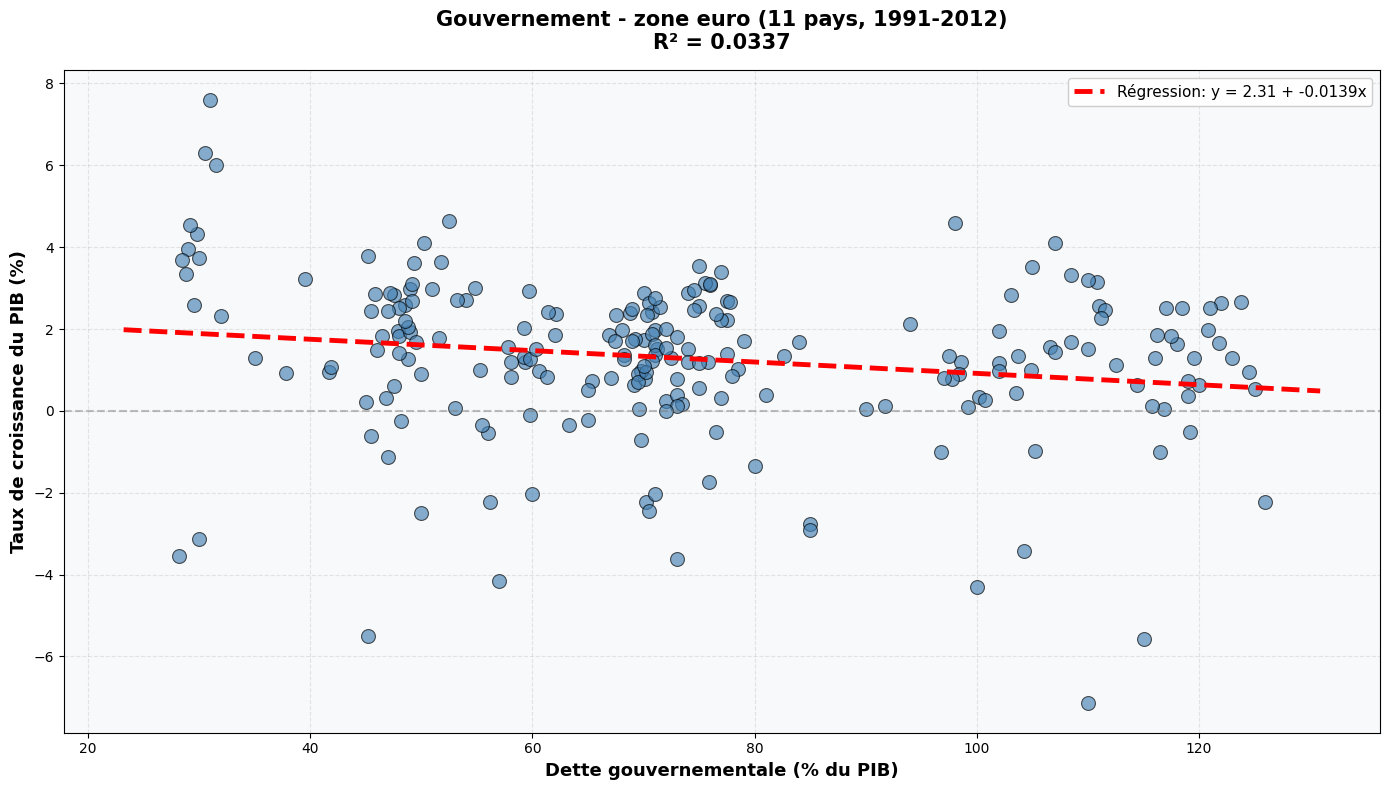

/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


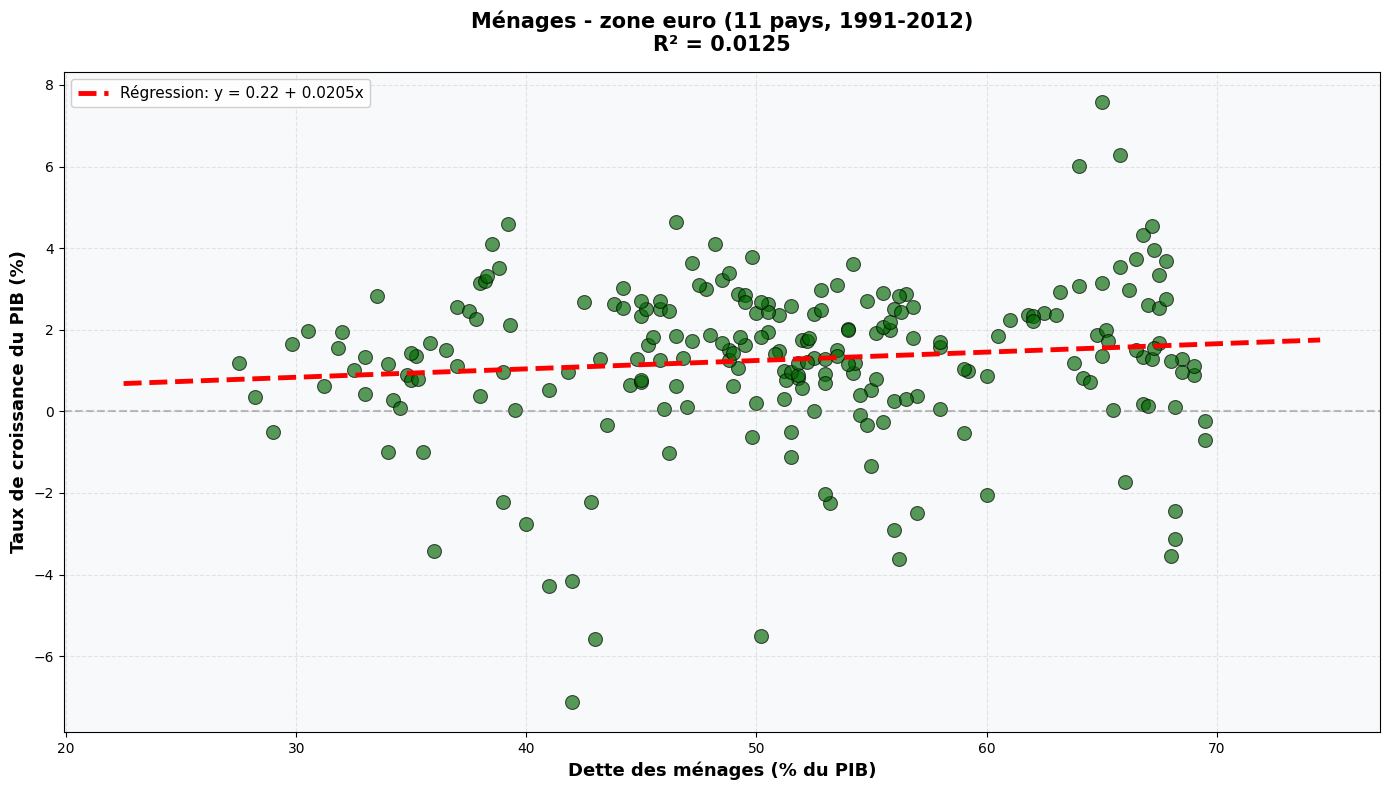

In [69]:
df_eurozone_complet = data_clean.construire_df_euro(df) # à vérifier les données copiées-collées
data_vis.reg_multi_pays(df_eurozone_complet)